# SLC Amplitude Time Series Analysis

This notebook reads Sentinel-1 SLC (Single Look Complex) data from zip files and generates an amplitude time series.

## Requirements
- `rasterio`
- `matplotlib`
- `numpy`
- `pandas`


In [2]:
import os
import glob
import zipfile
import re
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import pandas as pd
from datetime import datetime

# Configuration
DATA_DIR = "/home/ubuntu/work/slc_stack_test_subset/data/slcs"
SUB_SWATH = "iw1"
POLARIZATION = "vv"

print(f"Looking for data in: {DATA_DIR}")

Looking for data in: /home/ubuntu/work/slc_stack_test_subset/data/slcs


In [3]:
def get_slc_files(data_dir):
    slc_files = sorted(glob.glob(os.path.join(data_dir, "*.zip")))
    print(f"Found {len(slc_files)} SLC zip files.")
    return slc_files

def parse_date_from_filename(filename):
    # Example: S1A_IW_SLC__1SDV_20250310T113934_...
    match = re.search(r"(\d{8}T\d{6})", os.path.basename(filename))
    if match:
        return datetime.strptime(match.group(1), "%Y%m%dT%H%M%S")
    return None

slc_files = get_slc_files(DATA_DIR)
dates = [parse_date_from_filename(f) for f in slc_files]

df = pd.DataFrame({"filename": slc_files, "date": dates})
df = df.sort_values("date").reset_index(drop=True)
print(df.head())

Found 14 SLC zip files.
                                            filename                date
0  /home/ubuntu/work/slc_stack_test_subset/data/s... 2025-03-10 11:39:34
1  /home/ubuntu/work/slc_stack_test_subset/data/s... 2025-03-15 11:47:21
2  /home/ubuntu/work/slc_stack_test_subset/data/s... 2025-03-15 11:47:46
3  /home/ubuntu/work/slc_stack_test_subset/data/s... 2025-03-22 11:39:35
4  /home/ubuntu/work/slc_stack_test_subset/data/s... 2025-03-24 23:31:47


In [4]:
def read_slc_amplitude(zip_path, sub_swath="iw1", polarization="vv", downsample_factor=10):
    """
    Reads a specific TIFF from the SLC zip and calculates mean amplitude.
    Uses rasterio to read from zip.
    """
    # Construct the internal path pattern
    # measurement/s1a-iw1-slc-vv-20250310t113934-...
    # We need to list files in zip to find the exact name
    
    tiff_path = None
    with zipfile.ZipFile(zip_path, 'r') as z:
        for name in z.namelist():
            if f"measurement/s1" in name and sub_swath in name and polarization in name and name.endswith(".tiff"):
                tiff_path = name
                break
    
    if not tiff_path:
        print(f"Warning: Could not find {sub_swath} {polarization} in {os.path.basename(zip_path)}")
        return None
    
    # Read with rasterio
    full_path = f"zip://{zip_path}!{tiff_path}"
    try:
        with rasterio.open(full_path) as src:
            # Read a downsampled version to save memory
            # SLC is complex, usually read as one band of complex64 or similar, 
            # but rasterio might see it as 1 band.
            
            # Calculate new shape
            out_shape = (
                src.count,
                int(src.height / downsample_factor),
                int(src.width / downsample_factor)
            )
            
            data = src.read(
                out_shape=out_shape,
                resampling=rasterio.enums.Resampling.average
            )
            
            # Data is complex? Rasterio usually returns complex if the tiff is complex.
            # Let's check dtype
            if np.iscomplexobj(data):
                amplitude = np.abs(data)
            else:
                # If not complex, maybe it's already detected? Unlikely for SLC.
                # Or maybe it split into 2 bands? 
                # Usually S1 SLC TIFFs are complex int16.
                amplitude = np.abs(data)
                
            return np.mean(amplitude)
            
    except Exception as e:
        print(f"Error reading {zip_path}: {e}")
        return None

# Test on first file
mean_amp = read_slc_amplitude(df.iloc[0]['filename'])
print(f"Mean Amplitude of first scene: {mean_amp}")

Mean Amplitude of first scene: 10.116619110107422


In [5]:
# Process all files
amplitudes = []
valid_dates = []

print("Processing files...")
for idx, row in df.iterrows():
    amp = read_slc_amplitude(row['filename'])
    if amp is not None:
        amplitudes.append(amp)
        valid_dates.append(row['date'])
    else:
        print(f"Skipping {row['filename']}")

print(f"Processed {len(amplitudes)} files.")

Processing files...
Processed 14 files.


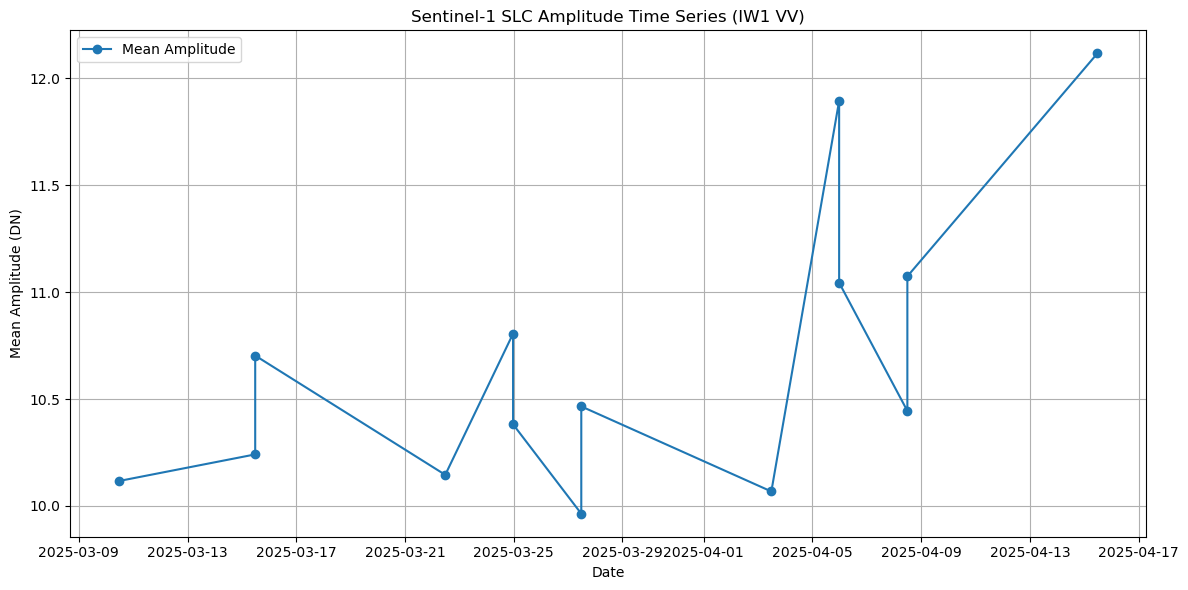

In [6]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(valid_dates, amplitudes, 'o-', label='Mean Amplitude')
plt.title(f"Sentinel-1 SLC Amplitude Time Series ({SUB_SWATH.upper()} {POLARIZATION.upper()})")
plt.xlabel("Date")
plt.ylabel("Mean Amplitude (DN)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("slc_amplitude_timeseries.png")
plt.show()